# CA4

### Imports

In [197]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

### Reading data

In [198]:

df = pd.read_csv('assets/train.csv', index_col=1)
df = df.drop(df.columns[0], axis=1)

### Data exploration and visualisation

In [199]:
# to get all the columns
pd.set_option('display.max_columns', None)
              
# Print the mean, median, and standard deviation of each column
print(df.head())
print(df.describe())


       AFP (ng/mL)    ALP (U/L)   ALT (U/L)  AST (U/L)  Age  Albumin (g/dL)  \
index                                                                         
1124     13.571425  1653.138489   40.405592  45.598427    4        4.477126   
1188     13.649342  1940.518305   21.336986  34.064095   55        3.190724   
530      10.898943  1557.369920   29.665496  16.044488   30        4.506351   
686      13.872275  1273.840525  142.418649  64.204257    0        3.665655   
296      10.102457  1461.622515   22.437303  23.940205   59        4.005109   

      Alcohol_Use (yes/no)  Bilirubin (mg/dL)  CRP (mg/L) Diabetes (yes/no)  \
index                                                                         
1124                   yes           0.541997    1.002121                no   
1188                   yes           1.199063    0.582746                no   
530                     no           0.740952    1.670375                no   
686                    yes           1.939879    1.

### Data cleaning

#### Turn categorical variables into numerical

In [200]:
# Turn the Categorical variables into number variables

label_to_number = LabelEncoder()
df['Alcohol_Use (yes/no)'] = label_to_number.fit_transform(df['Alcohol_Use (yes/no)'])
df['Diabetes (yes/no)'] = label_to_number.fit_transform(df['Diabetes (yes/no)'])
df['Obesity (yes/no)'] = label_to_number.fit_transform(df['Obesity (yes/no)'])
df['Gender'] = label_to_number.fit_transform(df['Gender'])

# Take this last to be able to transform back.
df['Diagnosis'] = label_to_number.fit_transform(df['Diagnosis']) # ".fit_transform" is short for ".fit" and then ".transform"


print(df.head())


numerical_column = [
    'AFP (ng/mL)',
    'ALP (U/L)',
    'ALT (U/L)',
    'AST (U/L)',
    'Age',
    'Albumin (g/dL)',
    'Bilirubin (mg/dL)',
    'CRP (mg/L)',
    'Fibroscan (kPa)',
    'GGT (U/L)',
    'Hemoglobin (g/dL)',
    'IL-6 (pg/mL)',
    'PT/INR',
    'Platelets (10^9/L)',
    'RBC (10^12/L)',
    'Serum_Ammonia (μmol/L)',
    'Serum_Copper (μg/dL)',
    'Serum_Creatinine (mg/dL)',
    'Serum_Iron (μg/dL)',
    'Serum_Lactate (mmol/L)',
    'Serum_Urea (mg/dL)',
    'Serum_Zinc (μg/dL)',
    'TIBC (μg/dL)',
    'Transferrin_Saturation (%)',
    'WBC (10^9/L)',
    'pH'
]

categorical_column = ['Alcohol_Use (yes/no)',
                      'Diabetes (yes/no)',
                      'Obesity (yes/no)',
                      'Gender']


       AFP (ng/mL)    ALP (U/L)   ALT (U/L)  AST (U/L)  Age  Albumin (g/dL)  \
index                                                                         
1124     13.571425  1653.138489   40.405592  45.598427    4        4.477126   
1188     13.649342  1940.518305   21.336986  34.064095   55        3.190724   
530      10.898943  1557.369920   29.665496  16.044488   30        4.506351   
686      13.872275  1273.840525  142.418649  64.204257    0        3.665655   
296      10.102457  1461.622515   22.437303  23.940205   59        4.005109   

       Alcohol_Use (yes/no)  Bilirubin (mg/dL)  CRP (mg/L)  Diabetes (yes/no)  \
index                                                                           
1124                      1           0.541997    1.002121                  0   
1188                      1           1.199063    0.582746                  0   
530                       0           0.740952    1.670375                  0   
686                       1           1.9

#### Remove missing values and outliers



In [201]:
# Check for nan values
print(df.isnull().values.any())

for i in numerical_column:
    z_score = (df[i] - np.mean(df[i])) / np.std(df[i])    
    df.loc[np.abs(z_score) > 4, i] = df[i].mean()


print(df.describe())

False


/var/folders/y7/rz4jr_2j0w944x4_4tv8n_jc0000gn/T/ipykernel_24599/3413737179.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '27.206258890469417' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[np.abs(z_score) > 4, i] = df[i].mean()


       AFP (ng/mL)    ALP (U/L)   ALT (U/L)   AST (U/L)         Age  \
count   703.000000   703.000000  703.000000  703.000000  703.000000   
mean     16.372944  1618.254304   58.262199   46.855946   27.206259   
std      29.003421   504.585379   36.372428   30.838523   23.632185   
min     -22.836893   546.609117  -14.313734  -16.215535    0.000000   
25%       8.029213  1229.735749   29.939330   24.163363    5.000000   
50%      10.195074  1553.771408   48.857238   38.720602   23.000000   
75%      12.656547  1928.613141   84.583900   70.023374   45.000000   
max     234.371973  3635.769850  178.226798  154.173314   86.000000   

       Albumin (g/dL)  Alcohol_Use (yes/no)  Bilirubin (mg/dL)  CRP (mg/L)  \
count      703.000000            703.000000         703.000000  703.000000   
mean         4.155568              0.321479           1.053063    1.823761   
std          0.432317              0.467377           0.609017    1.773394   
min          2.625845              0.000000     

### Data preprocessing and visualisation

#### Split data

In [202]:
y = df['Diagnosis']
X = df.drop(columns=['Diagnosis'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3,
    stratify=y, random_state=43)

### Modelling

In [204]:
pipeline_svc = Pipeline([('preprocessor', ColumnTransformer(
                            transformers=[('num', StandardScaler(), numerical_column)],
                            remainder='passthrough')),
                        ('pca', PCA()), # Choose the number of PCA components that cover 95% of the variance.
                        ('svc', SVC(max_iter=100000))])

C_range     = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] # For regularization parameter C.
gamma_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]         # For scaling parameter gamma in rbf-kernel.
random_state = [1, 10, 50, 100, 200, 500, 700, 1000]
kernal_range = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']

PCA_range = [0.85, 0.90, 0.95]

# Does anyone know why we have split up the parameter-grid into a list of dictionaries here?
param_grid = [{'svc__C': C_range, 'svc__kernel': kernal_range, 'svc__gamma': gamma_range, 'svc__random_state': random_state, 
               'pca__n_components': PCA_range}]

# Set up the grid search
gs_svc = GridSearchCV(estimator=pipeline_svc, 
                  param_grid=param_grid, 
                  scoring='f1_macro', 
                  cv=10,
                  n_jobs=-1,
                  verbose=1)

gs_svc_res = gs_svc.fit(X_train, y_train)
# Print results
print(gs_svc_res.best_score_)
print(gs_svc_res.best_params_)


Fitting 10 folds for each of 6720 candidates, totalling 67200 fits


/Users/bard/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/bard/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/bard/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/bard/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/bard/Library/Python/3.9/lib/python/site-packages/sklearn/

0.7414276987281323
{'pca__n_components': 0.95, 'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf', 'svc__random_state': 1}


/Users/bard/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [0.07495639 0.07495639 0.07495639 ...        nan        nan        nan]
  warnings.warn(


In [ ]:
pipeline_rf = Pipeline([('preprocessor', ColumnTransformer(
                            transformers=[('num', StandardScaler(), numerical_column)],
                            remainder='passthrough')),
                        ('pca', PCA()), # Choose the number of PCA components that cover 95% of the variance.
                        ('rf', RandomForestClassifier(random_state=1))])

param_grid = {'rf__n_estimators': [50, 100, 200, 300, 400, 500],
              'rf__criterion': ['gini', 'entropy', 'log_loss'],
                'rf__max_depth': [None, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                'pca__n_components': [0.85, 0.90, 0.95]}

gs_rf = GridSearchCV(estimator=pipeline_rf, 
                  param_grid=param_grid, 
                  scoring='f1_macro', 
                  cv=10,
                  n_jobs=-1,
                  verbose=1)

gs_rf_res = gs_rf.fit(X_train, y_train)
# Print results 
print(gs_rf_res.best_score_)
print(gs_rf_res.best_params_)


Fitting 10 folds for each of 540 candidates, totalling 5400 fits


0.891220288477251
{'pca__n_components': 0.95, 'rf__criterion': 'entropy', 'rf__max_depth': None, 'rf__n_estimators': 400}


In [ ]:
# Now with knn
from sklearn.neighbors import KNeighborsClassifier
pipeline_knn = Pipeline([('preprocessor', ColumnTransformer(
                            transformers=[('num', StandardScaler(), numerical_column)],
                            remainder='passthrough')), 
                        ('pca', PCA()), # Choose the number of PCA components that cover 95% of the variance.
                        ('knn', KNeighborsClassifier())])

param_grid = {'knn__n_neighbors': range(1, 100),
                'pca__n_components': [0.85, 0.90, 0.95]}
gs_knn = GridSearchCV(estimator=pipeline_knn, 
                  param_grid=param_grid, 
                  scoring='f1_macro', 
                  cv=10,
                  n_jobs=-1,
                  verbose=1)

gs_knn_res = gs_knn.fit(X_train, y_train)

# Print results
print(gs_knn_res.best_score_)
print(gs_knn_res.best_params_)

Fitting 10 folds for each of 297 candidates, totalling 2970 fits


0.5870357732288893
{'knn__n_neighbors': 8, 'pca__n_components': 0.85}


In [205]:
# Now with linear regression
from sklearn.linear_model import LogisticRegression


pipeline_lr = Pipeline([('preprocessor', ColumnTransformer(
                            transformers=[('num', StandardScaler(), numerical_column)],
                            remainder='passthrough')), 
                        ('pca', PCA()), # Choose the number of PCA components that cover 95% of the variance.
                        ('lr', LogisticRegression(max_iter=10000))])


multi_class = ['auto']
C =  [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0] # Regularization parameter
random_state = [1, 10, 50, 100, 200, 500, 700, 1000]
PCA_range = [0.80, 0.85, 0.90, 0.95]

param_grid = [{'lr__penalty': ['l2'],
                'lr__C': C,
                'lr__solver': ['lbfgs','newton-cg','newton-cholesky','sag'],
                'lr__multi_class': multi_class,
                'lr__random_state': random_state,
                'pca__n_components': PCA_range},
                {'lr__penalty': ['l1', 'l2'],
                'lr__C': C,
                'lr__solver': ['liblinear'],
                'lr__multi_class': multi_class,
                'lr__random_state': random_state,
                'pca__n_components': PCA_range},
                {'lr__penalty': ['elasticnet','l1', 'l2'],
                'lr__C': C,
                'lr__solver': ['saga'],
                'lr__multi_class': multi_class,
                'lr__random_state': random_state,
                'pca__n_components': PCA_range},]

gs_lr = GridSearchCV(estimator=pipeline_lr, 
                  param_grid=param_grid, 
                  scoring='f1_macro', 
                  cv=10,
                  n_jobs=-1,
                  verbose=1)

# Print results
gs_lr_res = gs_lr.fit(X_train, y_train)
print(gs_lr_res.best_score_)
print(gs_lr_res.best_params_)

#0.7359248442286921

Fitting 10 folds for each of 2016 candidates, totalling 20160 fits


(703, 30) (703,)


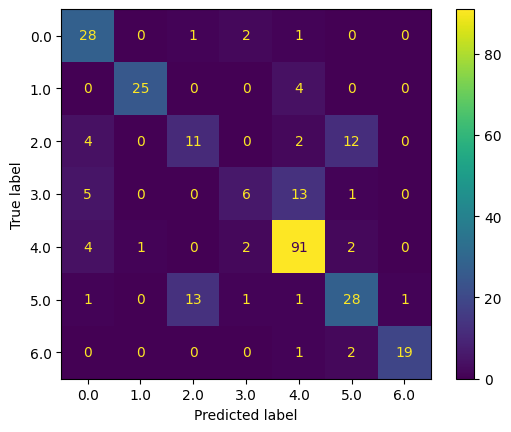

In [ ]:
print(X.shape, y.shape)
#split agian wiht 60/40
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4,
    stratify=y, random_state=42)

# Use best classifier
best_clf = gs_svc_res.best_estimator_
best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

### Final evaluation

In [ ]:
df = pd.read_csv('assets/train.csv')
df = df.drop(df.columns[0], axis=1)
df.set_index('index', inplace=True)

# Turn the Categorical variables into number variables
label_to_number = LabelEncoder()
df['Alcohol_Use (yes/no)'] = label_to_number.fit_transform(df['Alcohol_Use (yes/no)'])
df['Diabetes (yes/no)'] = label_to_number.fit_transform(df['Diabetes (yes/no)'])
df['Obesity (yes/no)'] = label_to_number.fit_transform(df['Obesity (yes/no)'])
df['Gender'] = label_to_number.fit_transform(df['Gender'])

df['Diagnosis'] = label_to_number.fit_transform(df['Diagnosis']) # ".fit_transform" is short for ".fit" and then ".transform"

# Take this last to be able to transform back.
y = df['Diagnosis'] # ".fit_transform" is short for ".fit" and then ".transform"
X = df.drop(columns=['Diagnosis'])


for i in df.columns:
    z_score = (df[i] - np.mean(df[i])) / np.std(df[i])    
    df.loc[np.abs(z_score) > 4, i] = df[i].mean()

gs_rf_res.best_estimator_.fit(X, y)
print(f'Train accuracy: {gs_lr_res.best_estimator_.score(X, y)}')



/var/folders/y7/rz4jr_2j0w944x4_4tv8n_jc0000gn/T/ipykernel_24599/3264240656.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '27.206258890469417' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[np.abs(z_score) > 4, i] = df[i].mean()
/var/folders/y7/rz4jr_2j0w944x4_4tv8n_jc0000gn/T/ipykernel_24599/3264240656.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.32147937411095306' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[np.abs(z_score) > 4, i] = df[i].mean()
/var/folders/y7/rz4jr_2j0w944x4_4tv8n_jc0000gn/T/ipykernel_24599/3264240656.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.22759601706970128' has dtype incompatible with int6

Train accuracy: 0.8165007112375533


### Kaggle submission

In [ ]:
df = pd.read_csv("assets/test.csv")
df = df.drop(df.columns[0], axis=1)
df.set_index('index', inplace=True)

# Turn the Categorical variables into number variables
gender_mapping = {'MALE': 0, 'FEMALE': 1}
df['Gender'] = df['Gender'].map(gender_mapping)

yes_no_mapping = {'no': 0, 'yes': 1}
df['Alcohol_Use (yes/no)'] = df['Alcohol_Use (yes/no)'].map(yes_no_mapping)
df['Diabetes (yes/no)'] = df['Diabetes (yes/no)'].map(yes_no_mapping)
df['Obesity (yes/no)'] = df['Obesity (yes/no)'].map(yes_no_mapping)

for i in df.columns:
    z_score = (df[i] - np.mean(df[i])) / np.std(df[i])    
    df.loc[np.abs(z_score) > 4, i] = df[i].mean()

y = gs_rf_res.best_estimator_.predict(df)
y = label_to_number.inverse_transform(y)
df_results = pd.DataFrame(data=y, columns=["Diagnosis"])
df_results.index.names = ["index"]
df_results.to_csv('assets/results.csv')

/var/folders/y7/rz4jr_2j0w944x4_4tv8n_jc0000gn/T/ipykernel_24599/3465274070.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '26.986754966887418' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[np.abs(z_score) > 4, i] = df[i].mean()
/var/folders/y7/rz4jr_2j0w944x4_4tv8n_jc0000gn/T/ipykernel_24599/3465274070.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.33112582781456956' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[np.abs(z_score) > 4, i] = df[i].mean()
/var/folders/y7/rz4jr_2j0w944x4_4tv8n_jc0000gn/T/ipykernel_24599/3465274070.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.20198675496688742' has dtype incompatible with int6

### Binary version of the target variables

In [ ]:
df = pd.read_csv('assets/train.csv', index_col=1)
df = df.drop(df.columns[0], axis=1)

# Turn the Categorical variables into number variables

label_to_number = LabelEncoder()
df['Alcohol_Use (yes/no)'] = label_to_number.fit_transform(df['Alcohol_Use (yes/no)'])
df['Diabetes (yes/no)'] = label_to_number.fit_transform(df['Diabetes (yes/no)'])
df['Obesity (yes/no)'] = label_to_number.fit_transform(df['Obesity (yes/no)'])
df['Gender'] = label_to_number.fit_transform(df['Gender'])

# print all values in diagnosis
print(df['Diagnosis'].unique())

Diagnosis_mapping = {'Healthy': 0, 
                     'Cirrhosis': 1, 'Drug-induced Liver Injury':1, 'Fatty Liver Disease': 1, 
                     'Hepatitis': 1, 'Autoimmune Liver Diseases': 1, 'Liver Cancer' : 1}
df['Diagnosis'] = df['Diagnosis'].map(Diagnosis_mapping)
# Take this last to be able to transform back.

print(df.head())



['Healthy' 'Cirrhosis' 'Drug-induced Liver Injury' 'Fatty Liver Disease'
 'Hepatitis' 'Autoimmune Liver Diseases' 'Liver Cancer']
       AFP (ng/mL)    ALP (U/L)   ALT (U/L)  AST (U/L)  Age  Albumin (g/dL)  \
index                                                                         
1124     13.571425  1653.138489   40.405592  45.598427    4        4.477126   
1188     13.649342  1940.518305   21.336986  34.064095   55        3.190724   
530      10.898943  1557.369920   29.665496  16.044488   30        4.506351   
686      13.872275  1273.840525  142.418649  64.204257    0        3.665655   
296      10.102457  1461.622515   22.437303  23.940205   59        4.005109   

       Alcohol_Use (yes/no)  Bilirubin (mg/dL)  CRP (mg/L)  Diabetes (yes/no)  \
index                                                                           
1124                      1           0.541997    1.002121                  0   
1188                      1           1.199063    0.582746               

In [ ]:
# Split the data into X and y
y = df['Diagnosis']
X = df.drop(columns=['Diagnosis'])

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Create a pipeline
pipeline_rf = Pipeline([('preprocessor', ColumnTransformer(
                            transformers=[('num', StandardScaler(), numerical_column)],
                            remainder='passthrough')),
                        ('pca', PCA()), # Choose the number of PCA components that cover 95% of the variance.
                        ('rf', RandomForestClassifier(random_state=1))])

param_grid = {'rf__n_estimators': [100, 200, 300, 400, 500],
                'rf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                'pca__n_components': [0.85, 0.90, 0.95]}

gs_rf = GridSearchCV(estimator=pipeline_rf, 
                  param_grid=param_grid, 
                  scoring='f1_macro', 
                  cv=5,
                  n_jobs=-1,
                  verbose=1)

gs_rf_res = gs_rf.fit(X_train, y_train)
# Print results
print(gs_rf_res.best_score_)
print(gs_rf_res.best_params_)



Fitting 5 folds for each of 150 candidates, totalling 750 fits


0.8910558821414156
{'pca__n_components': 0.95, 'rf__max_depth': 10, 'rf__n_estimators': 300}


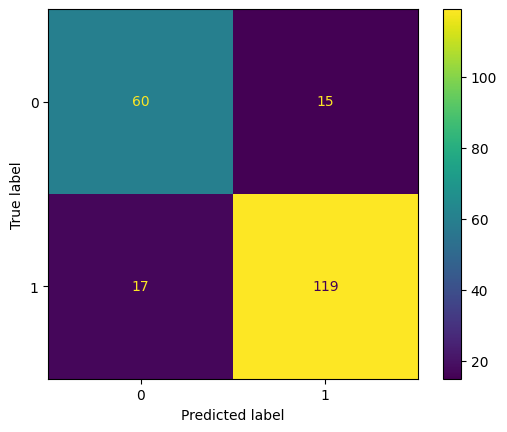

In [ ]:
best_clf = gs_rf_res.best_estimator_
best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

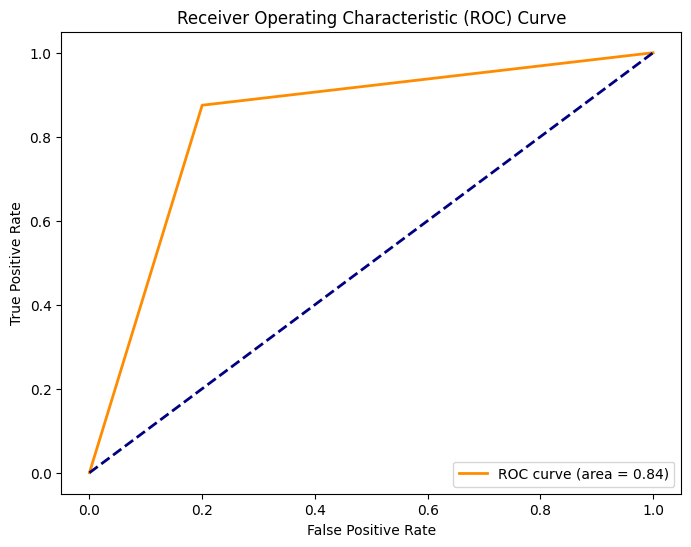

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()